# Modelo con Transfer Learning - VERSION ResNet50

In [5]:
import os 
import tensorflow as tf
import keras  
import numpy as np
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']='True' #Configuración para compatibilidad de matplotlib

## 1. Procesar imagenes


Partimos de un dataset con 9 categorias diferentes: ['Drought_Disaster', 'Earthquake_Disaster', 'LandSlide_Disaster', 'Non_Damage_Buildings_Street', 'Non_Damage_Sea', 'Non_Damage_Wildlife_Forest', 'Urban_Fire_Disaster', 'Water_Disaster', 'Wild_Fire_Disaster']

Cada carpeta cuenta con un nuemro diferente de imagenes, entre 200 y 4000 imagenes por clase.

Para la version de 'transfer learning', vamos a utilizar una version reducida de la base de datos debido al gran tiempo necesario para el entrenamiento , en el modelo de anterios usamos unas 600 imagenes por categoria y ahora se utilizaran unas 200. 
El modelo base será el 'ResNet50'

In [6]:
# Accedemos a la base de datos
train_dir='reduced_data'              #Guarda la ruto donde se encuentra la bases de datos
classes=os.listdir(data_dir)          #Obtiene el  nombre de las carpetas 
print(classes)

# Se determinan parámetros del conjunto con el que se trabajara
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

#Se crea la base de datos desde el directorio con keras
train_full = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    seed=42,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,    
)

['Drought_Disaster', 'Earthquake_Disaster', 'LandSlide_Disaster', 'Non_Damage_Buildings_Street', 'Non_Damage_Sea', 'Non_Damage_Wildlife_Forest', 'Urban_Fire_Disaster', 'Water_Disaster', 'Wild_Fire_Disaster']
Found 2675 files belonging to 9 classes.


## 2. División del conjunto

In [7]:
# Obtenemos la cantidad de batches y dividimos en 80/10/10
num_all_batches = len(list(train_full))
num_train_batches = int(num_all_batches * 0.8)
num_valid_test_batches = int(num_all_batches - num_train_batches)

# Imprimimos el número de lotes para el conjunto de datos de entrenamiento, validación y prueba
print(f'Number of  Train  batches : {num_train_batches}')
print(f'Number of Validation batches : {num_valid_test_batches//2}')
print(f'Number of Test batches : {num_valid_test_batches//2}')

Number of  Train  batches : 67
Number of Validation batches : 8
Number of Test batches : 8


In [8]:
# Dividimos con las funciones skit y take de keras
train_ds = train_full.take(num_train_batches)

remain = train_full.skip(num_train_batches)

valid_ds = remain.take(num_valid_test_batches//2)
test_ds = remain.skip(num_valid_test_batches//2)


In [9]:
# Visualizamos el tamaño y formato del conjunto
for x, y in test_ds.take(1):
    print("Image batch shape:", x.shape)
    print("Label batch shape:", y.shape)
    print("Example label:", y[0].numpy())

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 9)
Example label: [0. 0. 0. 0. 0. 0. 1. 0. 0.]


## 3. Modelo base ResNet50

Cargamos el modelo base con los pesos predeterminados al entrenar con el conjunto de imagenes de ImageNet y lo adaptamos para nuestro problema de 9 clases e imagenes de 224x224 en color RGB.

In [184]:
import keras 

# Cargar el modelo preentrenado ResNet50 con pesos de imagenet
pretrained_model = keras.applications.ResNet50(
    weights='imagenet', classes=9, input_shape=(224, 224, 3), include_top=False
)

In [185]:
# Visualizamos estrcutura modelo
pretrained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

Para nuestro modelo solo se entrenará la última capa del modelo ResNet50, el resto se bloqueará con los valores predeterminados

In [13]:
# Congela todas las capas, salvo las del último modulo.
pretrained_model.trainable = True                # Whole model is trainable
set_trainable = False                            # Set a flag to False

for layer in pretrained_model.layers :           # A loop over model's layers
    if layer.name == 'block5_conv1' :            # Define target layer's name (with if condition)
        set_trainable = True                     # Change flag value to True
    if set_trainable :                           # A condition for True flag
        layer.trainable = True                   # Set layer trainablity to True
    else :                                       # else condition
        layer.trainable = False                  # For layers befor our target layer

In [21]:
for layer in pretrained_model.layers:
    layer.trainable=False

In [188]:
# Congela las capas hasta llegar al último modulo.
pretrained_model.trainable = True     
for layer in pretrained_model.layers[:143]:
    layer.trainable=False


In [228]:
# Genera listado de la configuración de cada capa
for layer in pretrained_model.layers :
    print(layer.name,'"Trainable" set as:',layer.trainable)

input_3 "Trainable" set as: False
conv1_pad "Trainable" set as: False
conv1_conv "Trainable" set as: False
conv1_bn "Trainable" set as: False
conv1_relu "Trainable" set as: False
pool1_pad "Trainable" set as: False
pool1_pool "Trainable" set as: False
conv2_block1_1_conv "Trainable" set as: False
conv2_block1_1_bn "Trainable" set as: False
conv2_block1_1_relu "Trainable" set as: False
conv2_block1_2_conv "Trainable" set as: False
conv2_block1_2_bn "Trainable" set as: False
conv2_block1_2_relu "Trainable" set as: False
conv2_block1_0_conv "Trainable" set as: False
conv2_block1_3_conv "Trainable" set as: False
conv2_block1_0_bn "Trainable" set as: False
conv2_block1_3_bn "Trainable" set as: False
conv2_block1_add "Trainable" set as: False
conv2_block1_out "Trainable" set as: False
conv2_block2_1_conv "Trainable" set as: False
conv2_block2_1_bn "Trainable" set as: False
conv2_block2_1_relu "Trainable" set as: False
conv2_block2_2_conv "Trainable" set as: False
conv2_block2_2_bn "Trainable

## 4. Arquitectura del modelo

In [174]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [230]:
# Visualizamos el modelo base
model_base = Sequential()
model_base.add(pretrained_model)    
model_base.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
Total params: 23,587,712
Trainable params: 14,976,000
Non-trainable params: 8,611,712
_________________________________________________________________


In [192]:
# Añadimos capas personalizadas a nuestro modelo base
model = Sequential()
model.add(pretrained_model)                             # Añadimos nuestro modelo pre-entrenado
model.add(keras.layers.Dropout(0.5))                    # Usamos Dropout para evitar over-fitting
model.add(keras.layers.GlobalAveragePooling2D())        # Aplicamos GlobalAveragePooling2D
model.add(keras.layers.Flatten())                       # Convertimos la salida en un arraay de 1D
model.add(keras.layers.Dense(256, activation='relu'))   # Añadimos capa densa de 256 neuron con ReLU
model.add(keras.layers.Dropout(0.5))                    # Usamos Dropout para evitar over-fitting
model.add(keras.layers.Dense(9, activation='softmax'))  # Capa de salida con tantas neuronas como clases con 'softmax'

In [194]:
# Visualizamos las entradas y salida de cada capa
for layer in model.layers:
    print(f"Layer name: {layer.name}")
    print(f"  Input shape: {layer.input_shape}")
    print(f"  Output shape: {layer.output_shape}")
    print("-" * 10)

Layer name: resnet50
  Input shape: (None, 224, 224, 3)
  Output shape: (None, 7, 7, 2048)
----------
Layer name: dropout_5
  Input shape: (None, 7, 7, 2048)
  Output shape: (None, 7, 7, 2048)
----------
Layer name: global_average_pooling2d
  Input shape: (None, 7, 7, 2048)
  Output shape: (None, 2048)
----------
Layer name: flatten_5
  Input shape: (None, 2048)
  Output shape: (None, 2048)
----------
Layer name: dense_10
  Input shape: (None, 2048)
  Output shape: (None, 256)
----------
Layer name: dropout_6
  Input shape: (None, 256)
  Output shape: (None, 256)
----------
Layer name: dense_11
  Input shape: (None, 256)
  Output shape: (None, 9)
----------


In [196]:
# Visualizamos el modelo final
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 256)               524544    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                      

In [198]:
# Usamos CheckPoint Call-Back, para guardar los mejores parámetros como un archivo .keras
checkpoint_cb = keras.callbacks.ModelCheckpoint('MyModel_resnet.keras', save_best_only=True) 

# Early Stoping Call-Backc para parar el proceso de entrenamiento despueés de 'patience' épocas si no mejora
earlystop_cb = keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)

# ReduceLROnPlateau Call-Back para reducir la tasa de aprendizaje según el parámetro 'monitor' 
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

In [200]:
# Añadimos optimizador
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

## 5. Entrenamiento

In [203]:
# Entrenamos el modelo con la función .fit 
history = model.fit(
    train_ds, 
    epochs=15,                                         # Número de épocas
    validation_data=valid_ds,                          # Grupo de validación
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr] # Lista de reguladores
)

Epoch 1/15
67/67 [==============================] - 82s 1s/step - loss: 1.1198 - accuracy: 0.6325 - val_loss: 0.3988 - val_accuracy: 0.8594 - lr: 1.0000e-04
Epoch 2/15
67/67 [==============================] - 76s 1s/step - loss: 0.3393 - accuracy: 0.8881 - val_loss: 0.2658 - val_accuracy: 0.9062 - lr: 1.0000e-04
Epoch 3/15
67/67 [==============================] - 76s 1s/step - loss: 0.1748 - accuracy: 0.9417 - val_loss: 0.2096 - val_accuracy: 0.9258 - lr: 1.0000e-04
Epoch 4/15
67/67 [==============================] - 74s 1s/step - loss: 0.1080 - accuracy: 0.9636 - val_loss: 0.1779 - val_accuracy: 0.9453 - lr: 1.0000e-04
Epoch 5/15
67/67 [==============================] - 76s 1s/step - loss: 0.0734 - accuracy: 0.9739 - val_loss: 0.2328 - val_accuracy: 0.9336 - lr: 1.0000e-04
Epoch 6/15
67/67 [==============================] - 74s 1s/step - loss: 0.0573 - accuracy: 0.9795 - val_loss: 0.1880 - val_accuracy: 0.9453 - lr: 1.0000e-04
Epoch 7/15
67/67 [==============================] - 77s 1s

## 5. Evaluación 

Como medida de seguridad guardamos los datos del entrenamiento en un archivo CSV, por si es necesario acceder a ellos de nuevo.

In [205]:
import pandas as pd

# Convertir el resultado del entrenamiento a DataFrame
result_df = pd.DataFrame(history.history)

# Guardar el historial de entrenamiento (result_df) en un archivo CSV
result_df.to_csv('training_results_resnet.csv', index=False)


In [209]:
# # Callbacks devuelve los pesos del modelo base en "MyModel_resnet.keras"
# # Para cargarlos se utiliza keras.models.load_model
# best_model = keras.models.load_model('MyModel_resnet.keras')

In [13]:
# Evaluar el modelo en el grupo de test con model.evaluate()
loss, accuracy = model.evaluate(test_ds)
print(f'Loss : {loss}')
print(f'Accuracy : {accuracy*100}%')

9/9 [==============================] - 9s 692ms/step - loss: 0.2661 - accuracy: 0.9236
Loss : 0.26611462235450745
Accuracy : 92.36363768577576%


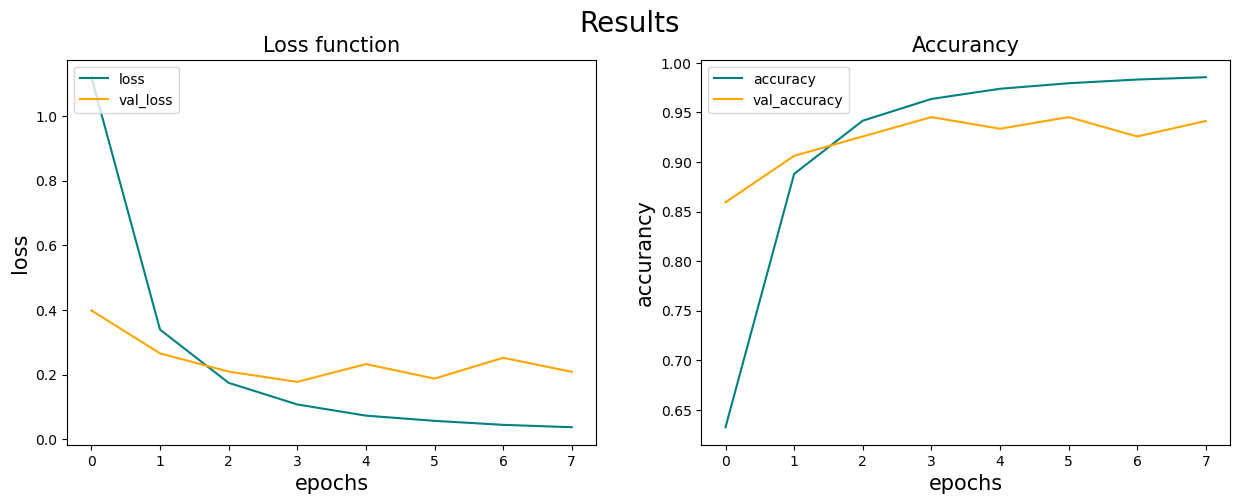

In [213]:
# Visualizar el proceso de entrenamiento
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15,5))
fig.suptitle('Results', fontsize=20)

plt.subplot(121)
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
plt.title('Loss function', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.legend(loc="upper left")

plt.subplot(122)
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('Accurancy', fontsize=15)
plt.ylabel('accurancy', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.legend(loc="upper left")

plt.show()
plt.close()

In [215]:
import numpy as np
import tensorflow as tf

# Calcular las predicciones sobre el conjunto de validación
y_true = []
y_pred = []

for images, labels in valid_ds:
    preds = model.predict(images)                     # Realiza la predicción
    y_pred.append(np.argmax(preds, axis=1))           # Agregar la clase predicha
    y_true.append(np.argmax(labels.numpy(), axis=1))  # Agregar la etiqueta verdadera

# Aplanar las listas de matrices en matrices 1D
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

1/1 [==============================] - 1s 800ms/step


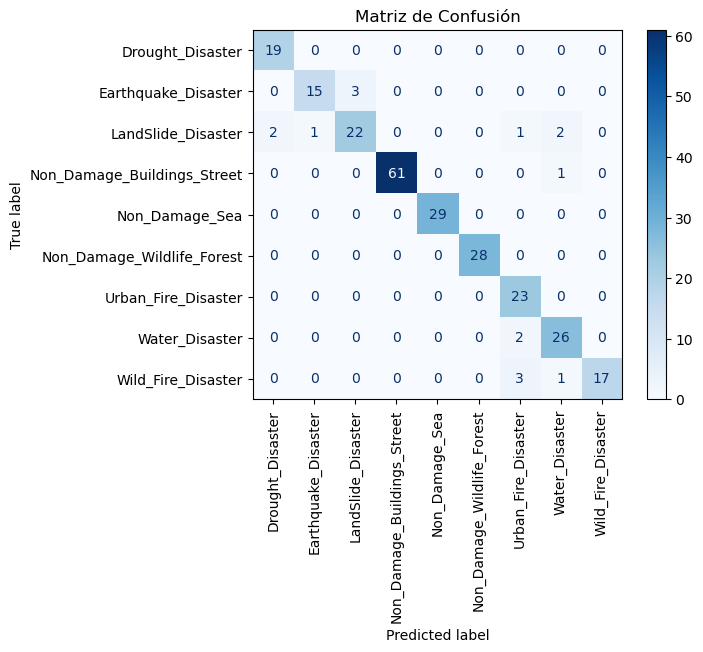

In [216]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#Obtiene el  nombre de las carpetas 
classes=os.listdir('reduce_data')    

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Mostrar con etiquetas de clase
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.title('Matriz de Confusión')
plt.show()
plt.close()

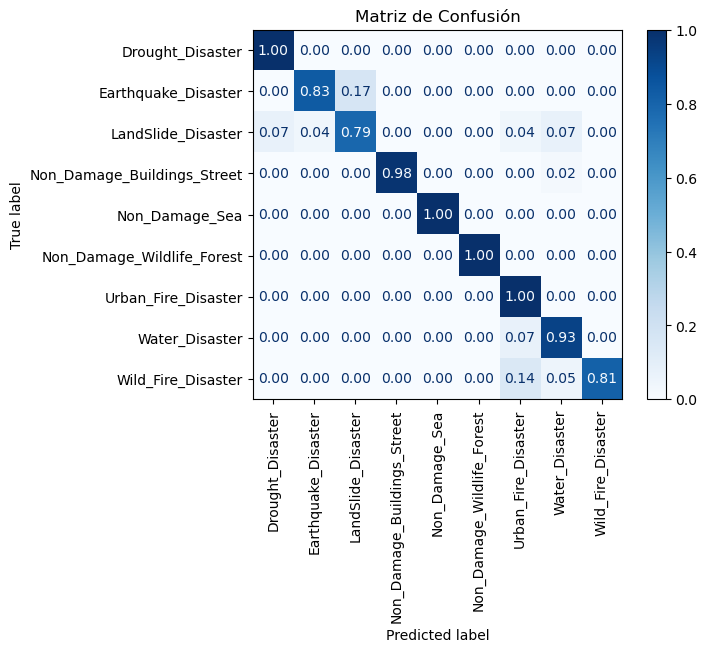

In [217]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Calcular la matriz de confusión normalizada (por filas)
cm = confusion_matrix(y_true, y_pred, normalize='true')  

# Mostrar con etiquetas de clase
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(xticks_rotation='vertical',cmap='Blues', values_format='.2f')  # Mostrar valores con decimales
plt.title('Matriz de Confusión')
plt.show()
plt.close()

## 6. Test

Se procede a analizar con profundidad el rendmiento en el grupo de pruba (imagenes que el modelo no ha visto)

In [221]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report

# Se obtiene las predicciones y las etiquetas correctas:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_pred.append(np.argmax(preds, axis=1))          # Convertir las precdicciones en indices de clase
    y_true.append(np.argmax(labels, axis=1))         # Convertir la etiquetas en formato one-hot

# Convertir a array de 1D
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Imprimir el informe con el nombre de las clases
class_names = train_full.class_names

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Precision (macro): 0.9137
Recall (macro): 0.9093
Accuracy: 0.9273

Classification Report:
                             precision    recall  f1-score   support

           Drought_Disaster       0.96      0.96      0.96        24
        Earthquake_Disaster       0.85      0.79      0.81        14
         LandSlide_Disaster       0.81      0.81      0.81        32
Non_Damage_Buildings_Street       0.99      0.99      0.99        80
             Non_Damage_Sea       0.96      1.00      0.98        25
 Non_Damage_Wildlife_Forest       1.00      1.00      1.00        29
        Urban_Fire_Disaster       0.80      0.92      0.86        26
             Water_Disaster       0.86      0.95      0.90        19
         Wild_Fire_Disaster       1.00      0.77      0.87        26

                   accuracy                           0.93       275
                  macro avg       0.91      0.91      0.91       275
               weighted avg       0.93      0.93      0.93       275



## 7. Guardar el modelo

Se guarda el modelo final con la función load.model en el directorio.

In [224]:
model.save(os.path.join('models','imageclassifier10_resnet.h5'))

## 8. Cargar el modelo

In [11]:
from tensorflow.keras.models import load_model

In [12]:
model = load_model(os.path.join('models', 'imageclassifier10_resnet.h5'))